In [1]:
import torch
from torch import nn
from torch.nn import functional as F

torch.manual_seed(42)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

# Data

In [2]:
with open("./data/tinyshakespeare.txt", "r", encoding="utf-8") as f:
    text = f.read()

text[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [4]:
class RandomSequenceDataset(torch.utils.data.Dataset):

    def __init__(self, data, context_size, length):
        self.data = data
        self.context_size = context_size
        self.length = length  # сколько примеров хотим на эпоху

    
    def __len__(self):
        return self.length

    
    def __getitem__(self, idx):
        # просто игнорируем idx и семплируем случайно
        i = torch.randint(0, len(self.data) - self.context_size - 1, (1,)).item()
        x = self.data[i : i+self.context_size]
        y = self.data[i+1 : i+1+self.context_size]
        
        return x, y

## Tokenizer

In [5]:
from collections import defaultdict
import numpy as np
import json


class Tokenizer:

    def __init__(self, merges_pth: str = None):
        merges = []
        if merges_pth:
            with open(merges_pth, "r", encoding="utf-8") as f:
                merges = json.load(f)
        self._init_vocab(merges)


    def _init_vocab(self, merges: list):
        self.merges = merges
        self.vocab = {idx: bytes([idx]) for idx in range(256)}
        for (a, b), token_id in merges:
            self.vocab[token_id] = self.vocab[a] + self.vocab[b]
    

    def _insert_token(tokens: list, token_pair: tuple, token_id: int):
        i, new_tokens = 0, []
        while i < len(tokens):
            if (i + 1 < len(tokens)) and (tokens[i] == token_pair[0]) and (tokens[i + 1] == token_pair[1]):
                new_tokens.append(token_id)
                i += 2
            else:
                new_tokens.append(tokens[i])
                i += 1
        
        return new_tokens
    

    def _calc_corpus_entropy(tokens: list):
        counts = defaultdict(int)  
        for token in tokens:
            counts[token] += 1
        probs = np.array(list(counts.values())) / len(tokens)
        
        return len(tokens) * -(np.log2(probs) * probs).sum()
    

    def encode(self, text: str):
        tokens = list(text.encode("utf-8"))
        for merge_pair, token_id in self.merges:
            tokens = Tokenizer._insert_token(tokens, merge_pair, token_id)
        
        return tokens


    def decode(self, tokens: list):
        byte_str = b"".join(self.vocab[token] for token in tokens)
        return byte_str.decode("utf-8", errors="replace")
    

    def save(self, dest_pth: str):
        with open(dest_pth, "w", encoding="utf-8") as f:
            json.dump(self.merges, f, indent=4, ensure_ascii=False)


    def fit(
            self,
            data: str,
            min_entropy_decrease_rate: float = -0.0005, 
            extention_step: int = 8, 
            extention_max: int = 2 ** 14,
        ):

        tokens = list(data.encode("utf-8"))
        prev_entropy = Tokenizer._calc_corpus_entropy(tokens)
        
        merges = []
        for _ in range(extention_max // extention_step):
            for _ in range(extention_step):
                new_token_id = len(merges) + 256

                counts = defaultdict(int)  # Поиск наиболее часто встречающейся пары токенов
                for a, b in zip(tokens, tokens[1:]):
                    p = (a, b)
                    counts[p] += 1
                token_pair = max(counts, key=counts.get)

                merges.append((token_pair, new_token_id))  # Сохранение информации о новой паре

                tokens = Tokenizer._insert_token(tokens, token_pair, new_token_id)  # Обновление последовательности токенов

            entropy = Tokenizer._calc_corpus_entropy(tokens)  # Подсчет общей энтропии для поиска оптимального размера словаря

            if entropy / prev_entropy - 1 > min_entropy_decrease_rate:
                break

            prev_entropy = entropy

        self._init_vocab(merges)

### Tokenizer.fit

In [21]:
tokenizer = Tokenizer()

tokenizer.fit(text)

In [32]:
print("vocab size:", len(tokenizer.vocab))
print("compression ratio:", len(text) / len(tokenizer.encode(text)))

vocab size: 1200
compression ratio: 2.6398483392580743


In [25]:
tokenizer.save("./data/tokenizer.json")

In [ ]:
from collections import defaultdict
import numpy as np


tokens = list(text.encode("utf-8"))
merges = []
vocab = {idx: bytes([idx]) for idx in range(256)}

extention_step = 8
extention_max = 2 ** 14
entropies = []
for _ in range(extention_max // extention_step):
    for i in range(extention_step):
        new_token_id = len(vocab)

        counts = defaultdict(int)  # Поиск наиболее часто встречающейся пары токенов
        for a, b in zip(tokens, tokens[1:]):
            p = (a, b)
            counts[p] += 1
        token_pair = max(counts, key=counts.get)

        merges.append((token_pair, new_token_id))  # Сохранение информации о новой паре
        vocab[new_token_id] = vocab[token_pair[0]] + vocab[token_pair[1]]

        tokens = Tokenizer._insert_token(tokens, token_pair, new_token_id)  # Обновление последовательности токенов

    counts = defaultdict(int)  # Подсчет общей энтропии для поиска оптимального размера словаря
    for token in tokens:
        counts[token] += 1
    probs = np.array(list(counts.values())) / len(tokens)
    corpus_entropy = len(tokens) * -(np.log2(probs) * probs).sum()
    entropies.append(corpus_entropy)

    if len(vocab) % 10 == 0:
        print("vocab_size:", len(vocab), "| corpus_entropy:", corpus_entropy)

vocab_size: 280 | corpus_entropy: 4975330.086398439
vocab_size: 320 | corpus_entropy: 4805149.419510091
vocab_size: 360 | corpus_entropy: 4666299.608182465
vocab_size: 400 | corpus_entropy: 4577916.605750768
vocab_size: 440 | corpus_entropy: 4507516.656907638
vocab_size: 480 | corpus_entropy: 4439799.273491572
vocab_size: 520 | corpus_entropy: 4387171.7812160775
vocab_size: 560 | corpus_entropy: 4345222.656484299
vocab_size: 600 | corpus_entropy: 4300924.329629338
vocab_size: 640 | corpus_entropy: 4263324.630974364
vocab_size: 680 | corpus_entropy: 4219596.190880939
vocab_size: 720 | corpus_entropy: 4188869.4018234275
vocab_size: 760 | corpus_entropy: 4144717.0175020457
vocab_size: 800 | corpus_entropy: 4111018.029972363
vocab_size: 840 | corpus_entropy: 4081690.1470774272
vocab_size: 880 | corpus_entropy: 4054991.7564962
vocab_size: 920 | corpus_entropy: 4028754.588778249
vocab_size: 960 | corpus_entropy: 4001871.7677996336
vocab_size: 1000 | corpus_entropy: 3975642.4716677032
vocab_s

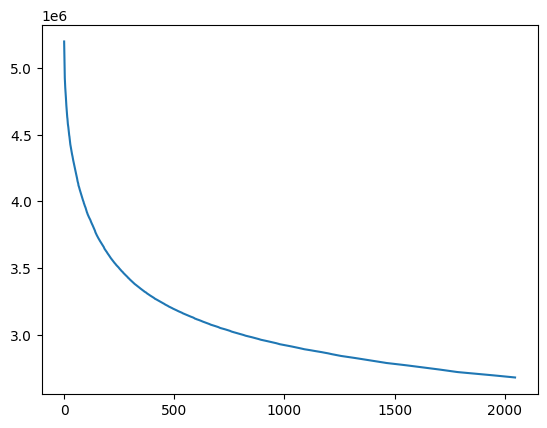

In [6]:
import matplotlib.pyplot as plt 


plt.plot(entropies)

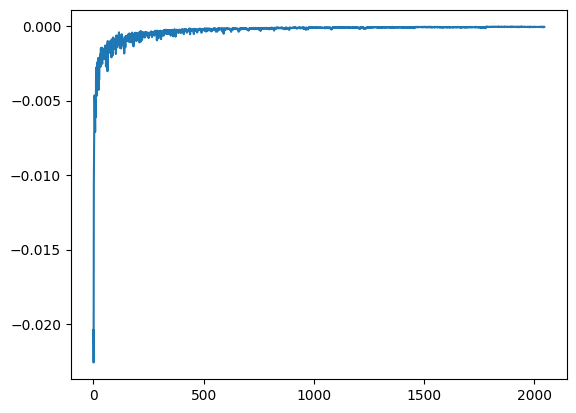

In [19]:
entropies_np = np.array(entropies)
decrease_rate = (entropies_np[1:] / entropies_np[:-1]) - 1

plt.plot(decrease_rate)

# Attention Idea

In [ ]:
b, t, c = 4, 8, 2
x = torch.randn(b, t, c)
x.shape

In [ ]:
# Нужно связать токен с предыдущими, но не с последующими
# К примеру, усреднение вектора текущего токена с предыдущими 
# (теряется информация о расположении токенов, неэффективное представление)

# Неэффективный последовательно выполняющийся вариант 
xbow = torch.zeros((b, t, c))
for i_b in range(b):
    for i_t in range(t):
        xprev = x[i_b, :i_t+1]
        xbow[i_b, i_t] = torch.mean(xprev, 0)

# Распараллеленный вариант с матричным умножением 
wei = torch.tril(torch.ones(t, t))  # треугольная матрица
wei /= wei.sum(1, keepdim=True)  # при t = 2: [[1, 0], [0.5, 0.5]]
xbow2 = wei @ x  # (t, t) @ (b, t, c) --broadcast--> (b, t, t) @ (b, t, c) -> (b, t, c)
print(torch.allclose(xbow, xbow2))

# С использованием Soft-Max
tril = torch.tril(torch.ones(t, t))
wei = torch.zeros((t, t))
wei = wei.masked_fill(tril == 0, float("-inf"))
wei = F.softmax(wei, dim=1)
xbow3 = wei @ x
print(torch.allclose(xbow, xbow3))

True
True


# Transformer Components  (Attention is all you need - 2017)

In [6]:
class SelfAttentionHead(nn.Module):

    def __init__(self, head_size, emb_dim, context_size, dropout=0.2):
        super().__init__()
        self.queries = nn.Linear(emb_dim, head_size, bias=False)
        self.keys = nn.Linear(emb_dim, head_size, bias=False)
        self.values = nn.Linear(emb_dim, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)  # Dropout: a simple way to prevent nn from overfitting (2014)

        self.register_buffer("tril", torch.tril(torch.ones(context_size, context_size)))

    
    def forward(self, idx):
        b, t, c = idx.shape
        
        wei = self.keys(idx) @ self.queries(idx).transpose(-2, -1) * c ** (-0.5)
        wei = wei.masked_fill(self.tril[:t, :t] == 0, float("-inf"))  # Диагональ применяется для блока декодера, 
                                                                      # в энкодер блоках допускается взаимосвязь между предыдущими и последующими токенами
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        return wei @ self.values(idx)
    

class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size, emb_dim, context_size, dropout=0.2):
        super().__init__()
        self.heads = nn.ModuleList([SelfAttentionHead(head_size, emb_dim, context_size) for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads * head_size, num_heads * head_size)
        self.dropout = nn.Dropout(dropout)

    
    def forward(self, idx):
        out = torch.cat([h(idx) for h in self.heads], dim=-1)
        out = self.proj(out)  # Линейное преобразование
        
        return self.dropout(out)
    

class FeedForward(nn.Module):

    def __init__(self, emb_dim, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_dim, 4 * emb_dim),
            nn.ReLU(),
            nn.Linear(4 * emb_dim, emb_dim),  # Линейное преобразование
            nn.Dropout(dropout),
        )

    
    def forward(self, idx):
        return self.net(idx)


class TrfBlock(nn.Module):
    
    def __init__(self, emb_dim, num_heads, context_size, dropout=0.2):
        super().__init__()
        self.sa_heads = MultiHeadAttention(
            num_heads=num_heads, 
            emb_dim=emb_dim,
            head_size=emb_dim // num_heads, 
            context_size=context_size,
            dropout=dropout,
        )
        self.ffwd_net = FeedForward(emb_dim, dropout=dropout)
        self.layer_norm1 = nn.LayerNorm(emb_dim)  # Layer Normalization (2016)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
    
    
    def forward(self, idx):
        x = idx + self.sa_heads(self.layer_norm1(idx))  # Deep Residual Learning for Image Recognition (2015)
        x = x + self.ffwd_net(self.layer_norm2(x))
        return x

# Model

In [7]:
class DecoderOnlyModel(nn.Module):
    
    def __init__(self, vocab_size, context_size, emb_dim, n_blocks, dropout=0.2):
        super().__init__()

        self.token_emb_table = nn.Embedding(vocab_size, emb_dim)
        self.positional_emb_table = nn.Embedding(context_size, emb_dim)
        self.blocks = nn.Sequential(*[
            TrfBlock(
                emb_dim=emb_dim, 
                num_heads=4, 
                context_size=context_size,
                dropout=dropout,
            ) for _ in range(n_blocks)
        ])
        self.layer_norm = nn.LayerNorm(emb_dim)
        self.classifier = nn.Linear(emb_dim, vocab_size)
            
    
    def forward(self, idx, targets=None):
        b, t = idx.shape

        tok_embs = self.token_emb_table(idx)  # batch_size x context_size x emb_dim
        pos_embs = self.positional_emb_table(torch.arange(t, device=idx.device))  # context_size x emb_dim
        x = tok_embs + pos_embs
        x = self.blocks(x)
        x = self.layer_norm(x)
        logits = self.classifier(x)  # (batch_size, context_size, emb_dim) @ (emb_dim, vocab_size) -> (batch_size, context_size, vocab_size)
        
        loss = None
        if targets is not None:
            batch_size, n_tensors, emb_dim = logits.shape
            logits = logits.view(batch_size * n_tensors, emb_dim)
            targets = targets.view(batch_size * n_tensors)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    

    def generate(self, idx, max_new_tokens, context_size):
        with torch.no_grad():
            for _ in range(max_new_tokens):
                idx_cond = idx[:, -context_size:]
                logits, _ = self(idx_cond)
                logits = logits[:, -1, :]  # Биграммная модель предсказывает, основываясь на последнем токене (-1)
                probs = F.softmax(logits, dim=-1)
                idx_next = torch.multinomial(probs, num_samples=1)  # Предсказание следующего токена
                idx = torch.cat((idx, idx_next), dim=1)
            
            return idx

# Train

In [14]:
context_size = 32  # what is the maximum context length for predictions?
batch_size = 128 # how many independent sequences will we process in parallel?
emb_dim = 32
n_blocks = 4
dropout = 0.15

tokenizer = Tokenizer("./data/tokenizer.json")
vocab_size = len(tokenizer.vocab)
data = torch.tensor(tokenizer.encode(text))
n = int(0.9 * len(data))

train_dataset = RandomSequenceDataset(data[:n], context_size=context_size, length=n)
val_dataset = RandomSequenceDataset(data[n:], context_size=context_size, length=len(data)-n)

dataloader_params = {"batch_size": batch_size, "num_workers": 0, "pin_memory": True}
train_dataloader = torch.utils.data.DataLoader(train_dataset, **dataloader_params)
val_dataloader = torch.utils.data.DataLoader(val_dataset, **dataloader_params)

model = DecoderOnlyModel(
    vocab_size=vocab_size,
    context_size=context_size,
    emb_dim=emb_dim,
    n_blocks=n_blocks,
    dropout=dropout,
).to(device)

print(sum(p.numel() for p in model.parameters()), "parameters")

129520 parameters


In [ ]:
from tqdm import tqdm 


epoches = 25

optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

train_lossi = []
for epoch in range(epoches):
    print(f"{epoch=}")

    lossi = []
    model.train()
    for x, y in tqdm(train_dataloader):

        x, y = x.to(device), y.to(device)
        logits, loss = model(x, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        lossi.append(loss.item())

    print("mean_train_loss:", sum(lossi) / len(lossi))
    train_lossi.extend(lossi)

    lossi = []
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(val_dataloader):

            x, y = x.to(device), y.to(device)
            logits, loss = model(idx=x, targets=y)

            lossi.append(loss.item())
    
    print("mean_val_loss:", sum(lossi) / len(lossi))

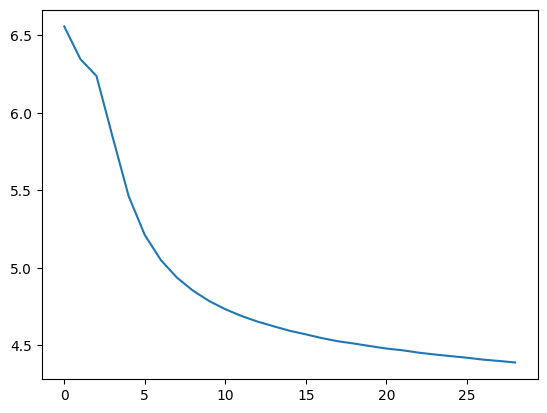

In [19]:
import matplotlib.pyplot as plt

plt.plot(torch.tensor(train_lossi[:29000]).view(-1, 1000).mean(1))

In [20]:
print(
    tokenizer.decode(
        model.generate(
            idx=torch.zeros((1, 1), dtype=torch.long, device=device), 
            max_new_tokens=1000, 
            context_size=context_size,
        )[0].tolist()
    )
)

 t
As I shoess, it manise you father happeway;
Watch-woman.

SW:
God were but we is Vencounten the very news do God die.

LAUDIUS:
NIXENES:
Why, thens in.

ESCAM:
Marcian't not the lassA:
Adanlont Peepon
Sain may.
Proalie with you for mean this y:
I comes not unam to Me, wheal hangence! thou good outy exchenpoor: my heal of both!
My vosting: say is not knew,
And myself, come, A my hear of fought, of counchacdious fore, my close by take himself,
But I havenon change that do not nes
put uponing earth as his daughter abjest
thereand weak a
him on
none thou I did pscatter my tay withnay, that in her sorutin all his asssoranneel infrests incal! By let me bett-promland p is scpiring-old without joimed
Of him;
Indagy, hold thee
For whock, smaseed the cons.

CAPUAIA:
Reashut from belill, falown!
Upit.
Now, ve's no age her, as Ihapphideech:
Now
Cabermt he must be love go! a both: inkly ts of quick actinted the peope;
Shange, so been hot herefore upon be you have come prit is h, inest tch beats 